In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
input_file = "../../test_data/system_tests/MaxQuant_Kuster200/evidence.txt"
maxquant_file = "../../test_data/system_tests/MaxQuant_Kuster200/proteinGroups.txt"
directlfq_file = "../../test_data/system_tests/MaxQuant_Kuster200/evidence.txt.protgroup_annotated.tsv.protein_intensities.tsv"

samplemap_directlfq = "../../test_data/system_tests/MaxQuant_Kuster200/samplemap_directlfq.tsv"

samplemap_maxquant = "../../test_data/system_tests/MaxQuant_Kuster200/samplemap_maxquant.tsv"
outfile = "../../test_data/system_tests/MaxQuant_Kuster200/cv_distribution_kuster200.pdf"
run_directlfq = True

In [3]:
if run_directlfq:
    import directlfq.lfq_manager as lfqmgr

    lfqmgr.run_lfq(input_file=input_file, input_type_to_use="maxquant_evidence", min_nonan=2, mq_protein_groups_txt=maxquant_file)


Starting directLFQ analysis.


/Users/constantin/workspace/directlfq/directlfq/utils.py:206: DtypeWarning: Columns (4,5,53,54,56,62) have mixed types. Specify dtype option on import or set low_memory=False.
  input_df = pd.read_csv(input_file, sep = "\t")


using input type maxquant_evidence


/Users/constantin/workspace/directlfq/directlfq/utils.py:605: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for input_df_subset in input_df_it:
/Users/constantin/workspace/directlfq/directlfq/utils.py:605: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for input_df_subset in input_df_it:
/Users/constantin/workspace/directlfq/directlfq/utils.py:605: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for input_df_subset in input_df_it:
/Users/constantin/workspace/directlfq/directlfq/utils.py:605: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for input_df_subset in input_df_it:
/Users/constantin/workspace/directlfq/directlfq/utils.py:605: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  for input_df_subset in input_df_it:


Performing sample normalization.
Estimating lfq intensities.
4019 prots total
using 10 processes
prot 0
Excluded 1 samples of 8 that were not connected to the rest of the samples.
Excluded 1 samples of 8 that were not connected to the rest of the samples.
Excluded 1 samples of 1 that were not connected to the rest of the samples.
Excluded 1 samples of 1 that were not connected to the rest of the samples.
Excluded 1 samples of 1 that were not connected to the rest of the samples.
Excluded 1 samples of 1 that were not connected to the rest of the samples.Excluded 1 samples of 1 that were not connected to the rest of the samples.

Excluded 1 samples of 1 that were not connected to the rest of the samples.
Excluded 1 samples of 6 that were not connected to the rest of the samples.Excluded 1 samples of 1 that were not connected to the rest of the samples.
Excluded 1 samples of 9 that were not connected to the rest of the samples.
Excluded 1 samples of 6 that were not connected to the rest o

In [7]:
import directlfq.benchmarking as lfqbenchmark
import pandas as pd

restable_directlfq = lfqbenchmark.ResultsTableBiological(results_file=directlfq_file, samplemap=samplemap_directlfq, name="directLFQ\n", protein_id="protein")
cvinfo_directlfq = lfqbenchmark.CVInfoDataset(restable_directlfq)

In [8]:

restable_maxlfq = lfqbenchmark.ResultsTableBiological(results_file=maxquant_file, samplemap=samplemap_maxquant, name = "MaxLFQ\n", protein_id="Protein IDs")
cvinfo_maxlfq = lfqbenchmark.CVInfoDataset(restable_maxlfq)

/Users/constantin/workspace/directlfq/directlfq/benchmarking.py:431: DtypeWarning: Columns (5,6,1624,1625,1626,1634,1635) have mixed types. Specify dtype option on import or set low_memory=False.
  self.results_df = pd.read_csv(self._results_file, sep = "\t")


5 are very large for directLFQ

3851
0.07184244470843683
0.06227412566319881
4 are very large for MaxLFQ

3809
0.06699086150939179
0.056207851082950865


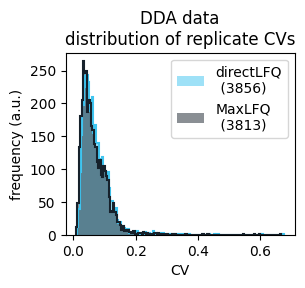

In [9]:
import matplotlib.pyplot as plt
ax = plt.subplot()
ax.figure.set_size_inches(1.25*2.363,2.363)
#initialize ax object with specified size

lfqbenchmark.CVDistributionPlotter(list_of_dataset_cv_infos=[cvinfo_directlfq, cvinfo_maxlfq], ax = ax,cumulative=False, density=False, bins=150)
ax.legend()


ax.set_title("DDA data\ndistribution of replicate CVs")
ax.set_xlabel("CV")
ax.set_ylabel('frequency (a.u.)')
plt.savefig(outfile, bbox_inches='tight', dpi=300)
plt.savefig(outfile.replace(".pdf", ".png"), bbox_inches='tight', dpi=300)